<a href="https://colab.research.google.com/github/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/blob/main/nlp_project/milestone_project_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lets reproduce a research paper and try to increase its accuracy**

PubMed 200k RCT: a Dataset for Sequential Sentence Classification in Medical Abstracts  [https://arxiv.org/abs/1710.06071]

# Dataset Used in Research Paper
[https://github.com/Franck-Dernoncourt/pubmed-rct]

In [1]:
# Clone Dataset Repository
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 13.95 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.


In [2]:
# Check files in cloned Dataset
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Check wgat files are in Dataset
!ls pubmed-rct/PubMed_200k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.zip


In [4]:
# Check wgat files are in Dataset
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [5]:
# start expermiments with lower dataset 20k and then we will move to 200k
data_dir="/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
# check all file names in the target directory

import os
filenames=[data_dir+filename for filename in os.listdir(data_dir) ]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

In [7]:
# Visualizing ( Become one with data)
def get_lines(filename):
    with open(filename) as f :
        return f.readlines()

In [8]:
train_lines=get_lines(data_dir+'train.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
len(train_lines)

210040

# **Preprocess Function**

**Desired Format for each abstract**

[{
'line_number':0,

'target':'BACKGROUND' or anything else,

'text':'Here goes Text',

total_lines:11 or any

}]

In [10]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""       # Create an empty abstract
    abstract_samples = []     # Create an empty list of abstracts

    # Loop through every line
    for line in input_lines:
        if line.startswith('###'):   # checks if line is ID
            abstract_id = line
            abstract_lines = ""      # resets the abstract string if line is ID

        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()  # Split abstract into separate lines

            # Iterate through each line in a single abstract and count them at the same time
            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)
        else:
            abstract_lines += line
    return abstract_samples


In [11]:
# get data from a file and preprocess it
%%time
train_samples=preprocess_text_with_line_numbers(data_dir+'train.txt')
val_samples=preprocess_text_with_line_numbers(data_dir+'dev.txt')
test_samples=preprocess_text_with_line_numbers(data_dir+'test.txt')

CPU times: user 557 ms, sys: 104 ms, total: 662 ms
Wall time: 887 ms


In [12]:
print(len(train_samples),len(val_samples),len(test_samples))

180040 30212 30135


In [13]:
# check the first abstract of the training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

**As our data is in the form of dictionaries we can change them into DataFrames** and further visualize it

In [14]:
import pandas as pd
train_df=pd.DataFrame(train_samples)
val_df=pd.DataFrame(val_samples)
test_df=pd.DataFrame(test_samples)

In [15]:
# Check now the distribution of the labels in the training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


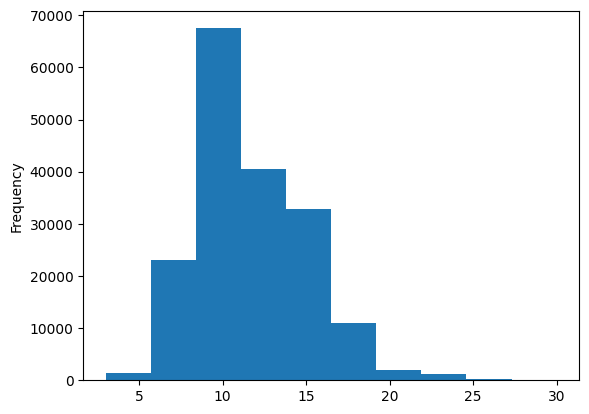

In [16]:
# cheking the length of different lines
train_df.total_lines.plot.hist();

In [17]:
# Getting the list of sentances
train_sentances=train_df['text'].to_list()
val_sentances=val_df['text'].to_list()
test_sentances=test_df['text'].to_list()

In [18]:
len(train_sentances)

180040

In [19]:
len(val_sentances)

30212

In [20]:
len(test_sentances)

30135

In [21]:
train_sentances[:10]   # View 10 lines of traiining sentenes

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

# **Make Numerical Labels (ML Models Require Numeric Labels)**

In [22]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder=OneHotEncoder(sparse_output=False)

train_label_one_hot=one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_label_one_hot=one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_label_one_hot=one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [23]:
train_label_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
# Label Encoded Labels     converting labels to integers
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()

train_label_encoded=label_encoder.fit_transform(train_df['target'].to_numpy())
val_label_encoded=label_encoder.fit_transform(val_df['target'].to_numpy())
test_label_encoded=label_encoder.fit_transform(test_df['target'].to_numpy())

In [25]:
train_label_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [26]:
# get class names and number of classes from Label Encoded instances
num_classes=len(label_encoder.classes_)
class_names=label_encoder.classes_
print(num_classes,class_names)

5 ['BACKGROUND' 'CONCLUSIONS' 'METHODS' 'OBJECTIVE' 'RESULTS']


# **Model_0 : Baseline Model**

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [28]:
# Create pipeline
model_0=Pipeline([
    ('tfid',TfidfVectorizer()),
    ('clf',MultinomialNB()),
])

In [29]:
# Fit the pipline to the training data
model_0.fit(X=train_sentances,y=train_label_encoded)

Pipeline(steps=[('tfid', TfidfVectorizer()), ('clf', MultinomialNB())])

In [30]:
# Evaluate Baseline model on validation dataset
model_0.score(X=val_sentances,y=val_label_encoded)

0.7218323844829869

In [31]:
# Predictions using a Baseline Model
baseline_preds=model_0.predict(val_sentances)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [32]:
# Download Helper Functions Scripts
!wget https://raw.githubusercontent.com/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/refs/heads/main/helper_functions.py

--2025-11-09 15:14:44--  https://raw.githubusercontent.com/FairozAhmadSheikh/DeepLearning_Bootcamp_with_Tensor_Flow/refs/heads/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6994 (6.8K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   6.83K  --.-KB/s    in 0s      

2025-11-09 15:14:45 (106 MB/s) - ‘helper_functions.py’ saved [6994/6994]



In [33]:
from helper_functions import calculate_results

In [34]:
# Calculate Baseline Results
baseline_results=calculate_results(y_true=val_label_encoded,y_pred=baseline_preds)
baseline_results

{'accuracy': 0.7218323844829869,
 'precsion': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1_score': 0.6989250353450294}

***Our Baseline Has an accuracyof 72% approximately***

# **Model_1 : Conv1D with token Embeddings**

we need first to do :

    1.   Text Vectorization
    2.   Embedding



In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [36]:
# how long is each sentance on average ?
sent_lens=[len(sentance.split()) for sentance in train_sentances]
avg_sent_len=np.mean(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

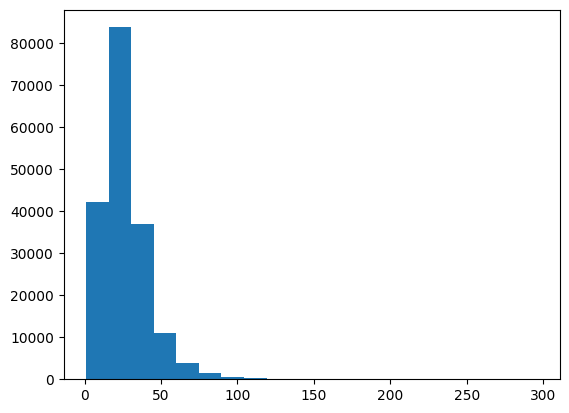

In [37]:
# what does the distribution look like
import matplotlib.pyplot as plt
plt.hist(sent_lens,bins=20)

In [38]:
# how long of sentances length cover 95% of examples?
output_seq_len=int(np.percentile(sent_lens,95))
output_seq_len

55

In [39]:
# Maximum Sequence length in the training set
max(sent_lens)

296

***Lets Create  a Text Vectorizer to map inputs(tokens) to numbersa***

In [40]:
max_tokens=68000  # as in the original research paper
from tensorflow.keras.layers import TextVectorization

text_vectorizer=TextVectorization(max_tokens=max_tokens,
                                  output_sequence_length=output_seq_len)

text_vectorizer.adapt(train_sentances)

In [41]:
# Test our text vectorizer on random sentanes
import random
target_sentence=random.choice(train_sentances)
print(f'Text :\n {target_sentence}')
print(f'\n Length of text :{len(target_sentence)}')
print(f'\n Vectorized Text :{text_vectorizer([target_sentence])}')


Text :
 the @ - and @-year patient survival rates were similar for both arms ( p = @ ) .

 Length of text :80

 Vectorized Text :[[  2   3 157 127 201 162   9 150  11  54 490  14   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [42]:
# how many words in our training vocabulary
rct_20k_text_vocab=text_vectorizer.get_vocabulary()
print(f'Number of words in vocab :{len(rct_20k_text_vocab)}')
print(f'Most common words in the vocab :{rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab :{rct_20k_text_vocab[-5:]}')

Number of words in vocab :64841
Most common words in the vocab :['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Least common words in the vocab :[np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [43]:
# get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [44]:
# Create custom text embedding
token_embed=tf.keras.layers.Embedding(
    input_dim=len(rct_20k_text_vocab),
    output_dim=128,
    mask_zero=True,name='token_embedding'
)

In [45]:
# show example embedding
print(f'Sentence before vectorization :\n{target_sentence}\n')
vectorized_sentence=text_vectorizer([target_sentence])
print(f'Sentence after vectorization ( Before Embedding) : \n{vectorized_sentence}')
embedded_sentence=token_embed(vectorized_sentence)
print(f'sentence after embedding : \ n {embedded_sentence}\n ')
print(f'Embedded Sentence Shape :{embedded_sentence.shape}')

Sentence before vectorization :
the @ - and @-year patient survival rates were similar for both arms ( p = @ ) .

Sentence after vectorization ( Before Embedding) : 
[[  2   3 157 127 201 162   9 150  11  54 490  14   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


<>:6: SyntaxWarning: invalid escape sequence '\ '
<>:6: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-2745396381.py:6: SyntaxWarning: invalid escape sequence '\ '
  print(f'sentence after embedding : \ n {embedded_sentence}\n ')


sentence after embedding : \ n [[[-0.02180832  0.0236251   0.00694164 ...  0.03153015  0.03276679
    0.02395984]
  [-0.00547902  0.0022187   0.03336701 ... -0.01678351  0.02759955
    0.00538278]
  [-0.03431529  0.02971223  0.00569953 ... -0.0316501   0.00134082
    0.01141126]
  ...
  [ 0.04354835 -0.0238547  -0.03518987 ...  0.01652174  0.04323668
    0.00214563]
  [ 0.04354835 -0.0238547  -0.03518987 ...  0.01652174  0.04323668
    0.00214563]
  [ 0.04354835 -0.0238547  -0.03518987 ...  0.01652174  0.04323668
    0.00214563]]]
 
Embedded Sentence Shape :(1, 55, 128)


# **Making Sure our Datasets load Faster using Tf.data API**

In [46]:
# Turn our data into tensorflow datasets
train_dataset=tf.data.Dataset.from_tensor_slices((train_sentances,train_label_one_hot))
test_dataset=tf.data.Dataset.from_tensor_slices((test_sentances,test_label_one_hot))
valid_dataset=tf.data.Dataset.from_tensor_slices((val_sentances,val_label_one_hot))

In [47]:
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
#Take the tensor slice datasets and turn them into prefetch  datasets
train_dataset=train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset=test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset=valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# **MODEL 1 : Conv1D with token embedding**

In [49]:
inputs=tf.keras.layers.Input(shape=(1,),dtype=tf.string)
text_vectors=text_vectorizer(inputs)
token_embeddings=token_embed(text_vectors)
x=layers.Conv1D(64,kernel_size=5,padding='same',activation='relu')(token_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_1=tf.keras.Model(inputs,outputs)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [50]:
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])



In [51]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Train the Model
history_model_1=model_1.fit(train_dataset,steps_per_epoch=int(0.1*len(train_dataset)),epochs=3,
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))


Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.5641 - loss: 1.1029 - val_accuracy: 0.7739 - val_loss: 0.5942
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7850 - loss: 0.5914 - val_accuracy: 0.8022 - val_loss: 0.5400
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.7989 - loss: 0.5450 - val_accuracy: 0.8068 - val_loss: 0.5268


In [53]:
# Evaluate on validataion dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8050 - loss: 0.5228


[0.5257117748260498, 0.8044154644012451]

In [54]:
model_1.evaluate(test_dataset)

942/942 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7996 - loss: 0.5420


[0.5393045544624329, 0.8018583059310913]

In [55]:
# Make Predictions
model_1_pred_probs=model_1.predict(valid_dataset)
model_1_pred_probs,model_1_pred_probs.shape

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


(array([[6.7899972e-01, 4.3216191e-02, 2.4492186e-03, 2.7231741e-01,
         3.0174425e-03],
        [2.8035831e-01, 5.6350273e-01, 1.1252624e-03, 1.5079762e-01,
         4.2160815e-03],
        [1.6956444e-01, 1.2476266e-02, 5.7055396e-03, 8.1159228e-01,
         6.6159473e-04],
        ...,
        [1.9049170e-04, 3.7742401e-03, 1.7792810e-02, 2.1351257e-04,
         9.7802895e-01],
        [1.6877819e-02, 6.7826182e-01, 2.1043550e-02, 7.7097737e-03,
         2.7610701e-01],
        [2.0167856e-02, 9.6514511e-01, 2.9644517e-03, 2.7146167e-03,
         9.0079671e-03]], dtype=float32),
 (30212, 5))

In [56]:
# Convert Pred probs to classes
model_1_preds=tf.argmax(model_1_pred_probs,axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [57]:
# Calculate Results
model_1_results=calculate_results(y_true=val_label_encoded,y_pred=model_1_preds)
model_1_results

{'accuracy': 0.8044154640540183,
 'precsion': 0.8025092182485262,
 'recall': 0.8044154640540183,
 'f1_score': 0.802703477790592}

# Model 1 beats Baseline Model

# ***Model 2  Feature extraction with pretrained token Embedding***

In [58]:
import tensorflow_hub as hub
url="https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding_layer=hub.KerasLayer(url,trainable=False,name='universal_sentence_encoder')

In [59]:
# Test out

random_train_sentence=random.choice(train_sentances)
print(f'Random Sentence :\n {random_train_sentence}')

Random Sentence :
 format included short lectures , case discussions , and a video modeling communication techniques .


In [60]:
use_embedded_sentences=tf_hub_embedding_layer([random_train_sentence])
print(f'Sentence after Embedding :\n {use_embedded_sentences[0][:30]}')
print(f'Length of sentence Embedding : {len(use_embedded_sentences[0])}')

Sentence after Embedding :
 [-0.05145648  0.06852631 -0.02063552 -0.06111945 -0.00846397 -0.00607065
 -0.0061217   0.08109844  0.01465502  0.00815843 -0.03444743 -0.05424273
 -0.05424657 -0.07295136 -0.05006847 -0.04333832  0.06783954  0.01683893
 -0.05318449 -0.06758516 -0.03349007  0.01046608 -0.05313213 -0.04606995
 -0.08164949 -0.05284604  0.01452503 -0.05606338 -0.00130753 -0.01615127]
Length of sentence Embedding : 512


In [61]:
# Building and Fit NLP Feature Extractor
# Custom wrapper layer for tf_hub_embedding_layer to handle KerasTensor binding issue
class UniversalSentenceEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(UniversalSentenceEncoderLayer, self).__init__(**kwargs)
        # The pre-loaded KerasLayer from TF-Hub
        self.pretrained_encoder = tf_hub_embedding_layer

    def call(self, inputs):
        # Pass the inputs through the pre-trained encoder
        return self.pretrained_encoder(inputs)

inputs=layers.Input(shape=[],dtype=tf.string)
# Use the custom wrapper layer to properly integrate the TF-Hub embedding
pretrained_embedding=UniversalSentenceEncoderLayer()(inputs)
x=layers.Dense(128,activation='relu')(pretrained_embedding)
outputs=layers.Dense(num_classes,activation='softmax')(x)
model_2=tf.keras.Model(inputs,outputs,name='model_2_USE_feature_extractor')

In [62]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'],
                jit_compile=False)

In [63]:
model_2.summary()

Model: "model_2_USE_feature_extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ universal_sentence_encoder_lay… │ (None, 512)            │             0 │
│ (UniversalSentenceEncoderLayer) │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,309 (259.02 KB)

 Trainable params: 66,309 (259.02 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
# Model_2 train
history_model_2=model_2.fit(train_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_dataset)),
                            validation_data=valid_dataset,
                            validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.5830 - loss: 1.0944 - val_accuracy: 0.6892 - val_loss: 0.7962
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7029 - loss: 0.7704 - val_accuracy: 0.7021 - val_loss: 0.7551
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.7144 - loss: 0.7559 - val_accuracy: 0.7154 - val_loss: 0.7391


In [65]:
# Evaluate on whole dataset
model_2.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7142 - loss: 0.7398


[0.7416146397590637, 0.7138885259628296]

In [66]:
# Make predictions
model_2_pred_probs=model_2.predict(valid_dataset)
model_2_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step


array([[4.3637511e-01, 3.5396674e-01, 3.4667249e-03, 1.9728726e-01,
        8.9041954e-03],
       [3.3029613e-01, 4.9560329e-01, 5.8220341e-03, 1.6515735e-01,
        3.1211982e-03],
       [2.5469089e-01, 1.4253485e-01, 2.1466808e-02, 5.4108775e-01,
        4.0219713e-02],
       ...,
       [1.7316892e-03, 5.7727210e-03, 5.4967284e-02, 8.1177580e-04,
        9.3671656e-01],
       [4.4088815e-03, 4.8124474e-02, 2.0324920e-01, 1.2038209e-03,
        7.4301362e-01],
       [1.5922755e-01, 2.2669649e-01, 5.5648363e-01, 7.4325223e-03,
        5.0159782e-02]], dtype=float32)

In [67]:
model_2_preds=tf.argmax(model_2_pred_probs,axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [68]:
# Calcualate Result for model_2
model_2_results=calculate_results(y_true=val_label_encoded,
                                  y_pred=model_2_preds)
model_2_results

{'accuracy': 0.7138885211174367,
 'precsion': 0.7145887866305963,
 'recall': 0.7138885211174367,
 'f1_score': 0.7111244469972248}

*Model 2 does not beat Baseline or Model 1's accuracy*

# **Lets Now Build Model3 :**

1.  Conv1D with character Encoding

In [69]:
# Make a function that splits the sentences to the characters
def split_chars(text):
    return " ".join(list(text))

In [70]:
# Example use-case
split_chars(random_train_sentence)

'f o r m a t   i n c l u d e d   s h o r t   l e c t u r e s   ,   c a s e   d i s c u s s i o n s   ,   a n d   a   v i d e o   m o d e l i n g   c o m m u n i c a t i o n   t e c h n i q u e s   .'

In [71]:
# Split sequence level data into into character level data splits
train_chars=[split_chars(sentence) for sentence in train_sentances]
val_chars=[split_chars(sentence) for sentence in val_sentances]
test_chars=[split_chars(sentence) for sentence in test_sentances]

In [72]:
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [73]:
# find average length of chars
char_lens=[len(sentence) for sentence in train_sentances]
mean_char_lens=np.mean(char_lens)
mean_char_lens

np.float64(149.3662574983337)

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

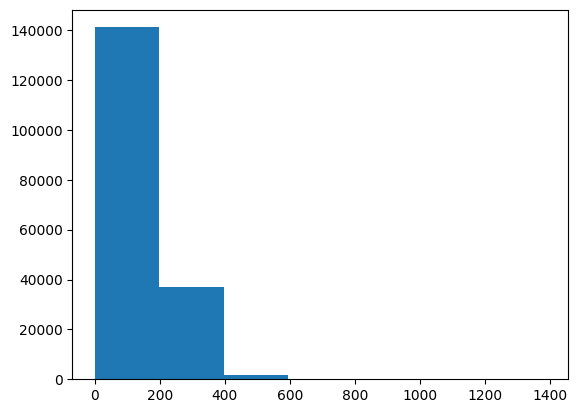

In [74]:
# Finding the distribution character level
import matplotlib.pyplot as plt
plt.hist(char_lens,bins=7)

In [75]:
# finding what character lenght covers 95% of sequences
output_seq_char_len=int(np.percentile(char_lens,95))
output_seq_char_len

290

In [76]:
# Getting all keyboard Characters
import string
alphabet=string.ascii_lowercase+string.digits+string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
len(alphabet)

68

In [78]:
# Create a char level token vectorizer instances
NUM_CHAR_TOKENS=len(alphabet) + 2  # Two added for SPACE & OOV [out of vocab] Token
char_vectorizer=TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                  output_sequence_length=output_seq_char_len,
                                  name='char_vectorizer')

In [79]:
char_vectorizer.adapt(train_chars)

In [80]:
# Check character Voacb stats
char_vocab=char_vectorizer.get_vocabulary()
print(f'Number of different characters in character vocab {len(char_vocab)}')
print(f'Five Most common characters {char_vocab[:5]}')
print(f'Five Least common characters {char_vocab[-5:]}')

Number of different characters in character vocab 28
Five Most common characters ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
Five Least common characters [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [81]:
# Test our character Vectorizer
random_train_chars=random.choice(train_chars)
print(f'Charified Text : \n {random_train_chars}')
print(f'Lenth of Random train chars : {len(random_train_chars)}')
vectorized_chars=char_vectorizer([random_train_chars])
print(f'\n Vectorized Chars :\n {vectorized_chars}')
print(f'\n Length of Vectorized chars :{len(vectorized_chars[0])}')

Charified Text : 
 a l p i n s   v e c t o r   a n a l y s i s   o f   a s t i g m a t i s m   w a s   p e r f o r m e d   u s i n g   m a n i f e s t   r e f r a c t i o n   m e a s u r e d   p r e o p e r a t i v e l y   a n d   @   m o n t h s   p o s t o p e r a t i v e l y   a n d   v e r t e x e d   t o   t h e   c o r n e a l   p l a n e   .
Lenth of Random train chars : 331

 Vectorized Chars :
 [[ 5 12 14  4  6  9 21  2 11  3  7  8  5  6  5 12 19  9  4  9  7 17  5  9
   3  4 18 15  5  3  4  9 15 20  5  9 14  2  8 17  7  8 15  2 10 16  9  4
   6 18 15  5  6  4 17  2  9  3  8  2 17  8  5 11  3  4  7  6 15  2  5  9
  16  8  2 10 14  8  2  7 14  2  8  5  3  4 21  2 12 19  5  6 10 15  7  6
   3 13  9 14  7  9  3  7 14  2  8  5  3  4 21  2 12 19  5  6 10 21  2  8
   3  2 24  2 10  3  7  3 13  2 11  7  8  6  2  5 12 14 12  5  6  2  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 

In [82]:
# Character Level encoding
char_embed=layers.Embedding(
    input_dim=len(char_vocab),
    output_dim=25,
    mask_zero=True,
    name='char_embed'
)

In [83]:
# Test Our embedding
print(f'charified text :\n {random_train_chars}\n')
char_embed_example=char_embed(char_vectorizer([random_train_chars]))
print(f'Embedded chars (After Vectorization and Embedding ) \n{char_embed_example}')
print(f'character embedding shape:  {char_embed_example.shape}')

charified text :
 a l p i n s   v e c t o r   a n a l y s i s   o f   a s t i g m a t i s m   w a s   p e r f o r m e d   u s i n g   m a n i f e s t   r e f r a c t i o n   m e a s u r e d   p r e o p e r a t i v e l y   a n d   @   m o n t h s   p o s t o p e r a t i v e l y   a n d   v e r t e x e d   t o   t h e   c o r n e a l   p l a n e   .

Embedded chars (After Vectorization and Embedding ) 
[[[-0.02727385 -0.03149164  0.00936333 ... -0.01485581  0.02586723
   -0.00821036]
  [ 0.02374348 -0.01220755 -0.00681716 ...  0.02538735 -0.04552751
    0.04151866]
  [ 0.00641538 -0.03938103 -0.01074434 ... -0.01022357 -0.02375574
   -0.04930321]
  ...
  [-0.02295261  0.00679418  0.04031768 ...  0.04081373  0.02427122
   -0.00385748]
  [-0.02295261  0.00679418  0.04031768 ...  0.04081373  0.02427122
   -0.00385748]
  [-0.02295261  0.00679418  0.04031768 ...  0.04081373  0.02427122
   -0.00385748]]]
character embedding shape:  (1, 290, 25)


In [84]:
# Model 3 : Character Level Conv1D model
inputs=layers.Input(shape=(1,),dtype='string')
char_vectors=char_vectorizer(inputs)
char_embeddings=char_embed(char_vectors)
x= layers.Conv1D(64,activation='relu',kernel_size=5,padding='same')(char_embeddings)
x=layers.GlobalMaxPooling1D()(x)
outputs=layers.Dense(num_classes,activation='softmax')(x)

model_3=tf.keras.Model(inputs=inputs,outputs=outputs,name='Model_3_conv1D_char_embedding')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [85]:
model_3.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [86]:
model_3.summary()

Model: "Model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,089 (35.50 KB)

 Trainable params: 9,089 (35.50 KB)

 Non-trainable params: 0 (0.00 B)

# ***Optimize Dataset for charcter level***

In [87]:
train_char_dataset=tf.data.Dataset.from_tensor_slices((train_chars,train_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset=tf.data.Dataset.from_tensor_slices((val_chars,val_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset=tf.data.Dataset.from_tensor_slices((test_chars,test_label_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
# Model Trained
history_model_3=model_3.fit(train_char_dataset,
                            epochs=3,
                            steps_per_epoch=int(0.1*len(train_char_dataset)),
                            validation_data=val_char_dataset,
                            validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4210 - loss: 1.4037 - val_accuracy: 0.5871 - val_loss: 1.0435
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5784 - loss: 1.0433 - val_accuracy: 0.6203 - val_loss: 0.9503
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.6263 - loss: 0.9527 - val_accuracy: 0.6533 - val_loss: 0.8790


In [89]:
# Make Predictions with character model only
model_3_pred_probs=model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


array([[0.14181611, 0.3291353 , 0.11863875, 0.36104292, 0.04936689],
       [0.28955108, 0.49610102, 0.02102781, 0.13306418, 0.0602559 ],
       [0.07169025, 0.48086944, 0.17466219, 0.08894449, 0.18383369],
       ...,
       [0.07520135, 0.18418854, 0.09083208, 0.08688781, 0.5628902 ],
       [0.03792645, 0.25656483, 0.4009117 , 0.04568312, 0.2589139 ],
       [0.6036423 , 0.22860718, 0.11048896, 0.04748311, 0.00977847]],
      dtype=float32)

In [90]:
# Convert Prediction probabilities to class labels
model_3_preds=tf.argmax(model_3_pred_probs,axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 1, ..., 4, 2, 0])>

In [91]:
# calculate results for Conv1D model chars only
model_3_results=calculate_results(y_true=val_label_encoded,y_pred=model_3_preds)
model_3_results

{'accuracy': 0.6458360916192242,
 'precsion': 0.6431136245533918,
 'recall': 0.6458360916192242,
 'f1_score': 0.6353765094026189}

`Worst Model Till Now  Model 3 `

# **Model 4 :Multimodel**

Here we will be doing using two  things
  1.   Combining pretrained Embedding  and
  2.   Character Embedding



In [92]:
# Setup tokens inputs and outputs

token_inputs=layers.Input(shape=[],dtype='string')
token_embeddings=UniversalSentenceEncoderLayer()(token_inputs)
token_output=layers.Dense(128,activation='relu')(token_embeddings)
token_model=tf.keras.Model(inputs=token_inputs,outputs=token_output)

In [131]:
char_inputs=layers.Input(shape=(1,),dtype='string',name="char_input")
char_vectors=char_vectorizer(char_inputs)
char_embeddings=char_embed(char_vectors)
char_bi_lstm=layers.Bidirectional(layers.LSTM(25, use_cudnn=False))(char_embeddings)
char_model=tf.keras.Model(char_inputs,char_bi_lstm)

In [113]:
# concatenate token and char inputs (create hybrid embeddings)
token_char_concat=layers.Concatenate(name='token_class_hybrid')([token_model.output,char_model.output])

In [114]:
# Create output layer adding in Dropout , Discussed in section 4.2  in research paper
combined_dropout=layers.Dropout(0.5)(token_char_concat)
combined_dense=layers.Dense(128,activation='relu')(combined_dropout)
final_dropout=layers.Dropout(0.5)(combined_dense)
output_layer=layers.Dense(num_classes,activation='softmax')(final_dropout)

In [115]:
# Construct Model with char and token inputs
model_4=tf.keras.Model(inputs=[token_model.input,char_model.input],outputs=output_layer,name='model_4_token_and_char_embeddings')

In [116]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ input_layer_3[0]… │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 290)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 50)        │     10,200 │ char_embed[6][0], │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_class_hybrid  │ (None, 178)       │          0 │ dense_4[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 178)       │          0 │ token_class_hybr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     22,912 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │        645 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,121 (391.10 KB)

 Trainable params: 100,121 (391.10 KB)

 Non-trainable params: 0 (0.00 B)

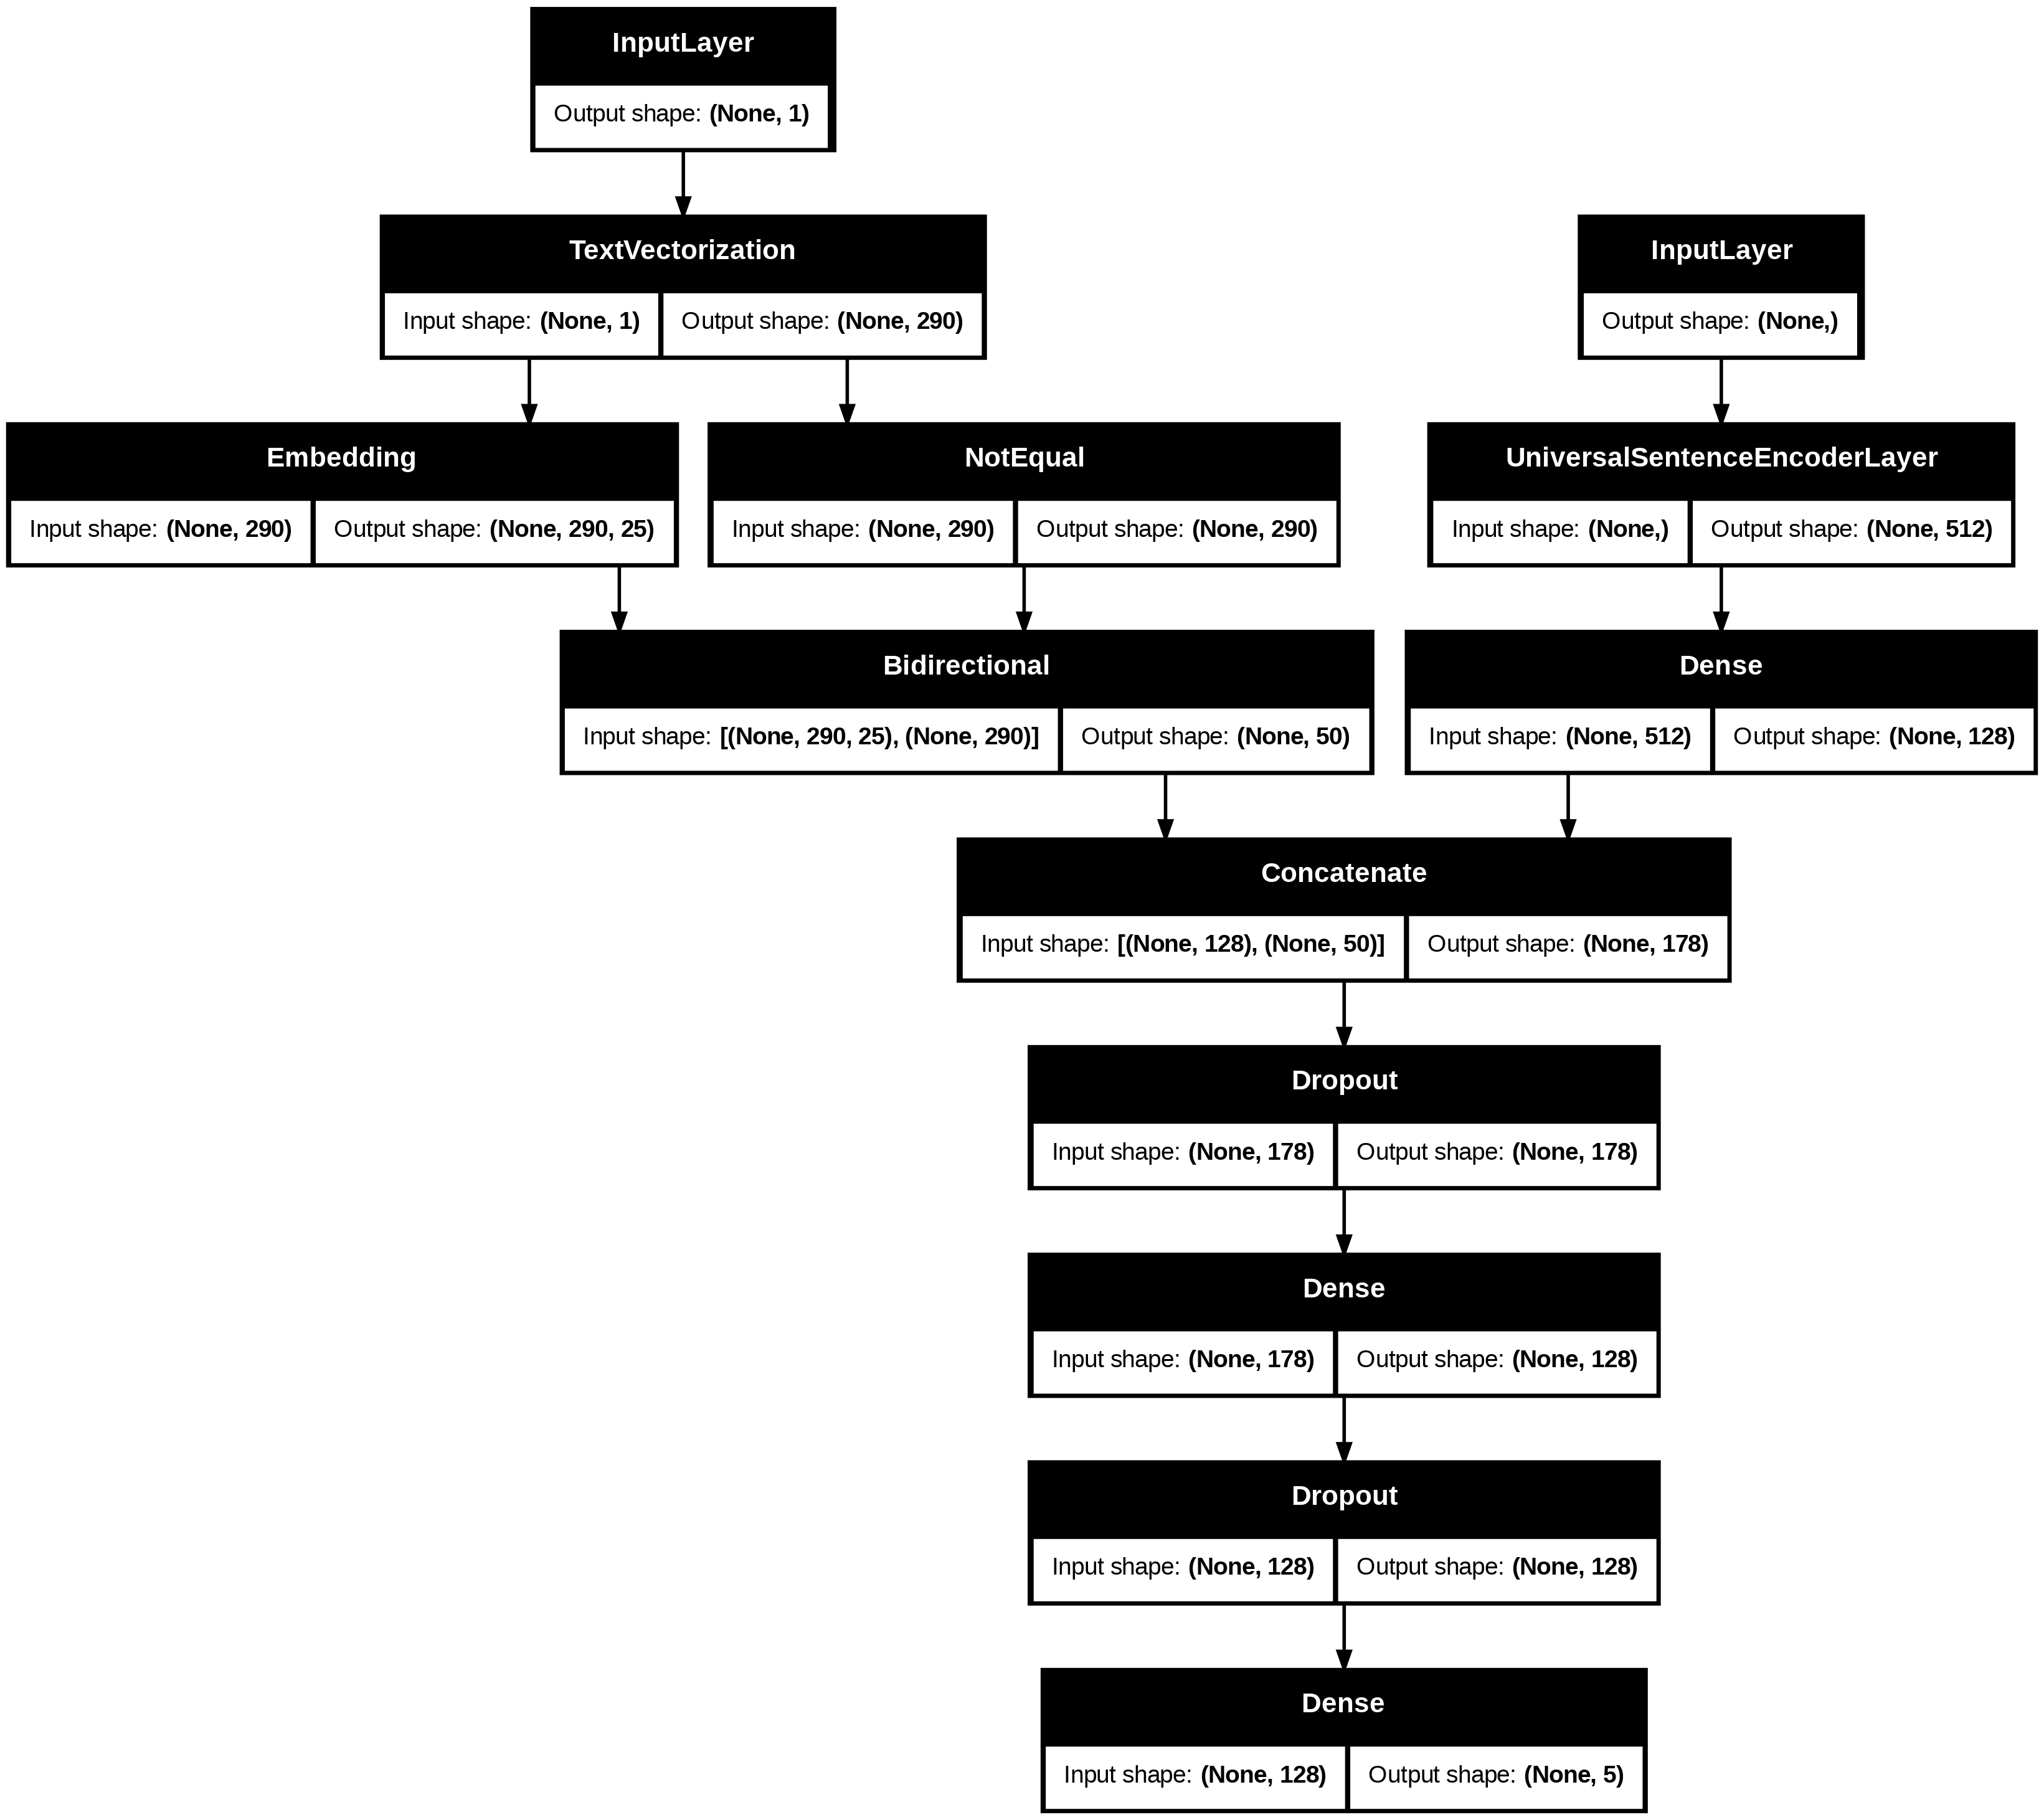

In [117]:
# Plot Hybrid token chracter Model 4
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [118]:
# Compile the Model 4
model_4.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

In [119]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentances, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_label_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [120]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentances, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_label_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [121]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [122]:
# Fit the model on tokens and chars
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))


Epoch 1/3
144/562 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.4988 - loss: 1.2426

InvalidArgumentError: Graph execution error:

Detected at node model_4_token_and_char_embeddings_1/bidirectional_5_1/forward_lstm_5_1/Assert/Assert defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.12/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.12/dist-packages/tornado/platform/asyncio.py", line 211, in start

  File "/usr/lib/python3.12/asyncio/base_events.py", line 645, in run_forever

  File "/usr/lib/python3.12/asyncio/base_events.py", line 1999, in _run_once

  File "/usr/lib/python3.12/asyncio/events.py", line 88, in _run

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.12/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-426203078.py", line 2, in <cell line: 0>

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 377, in fit

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 220, in function

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 133, in multi_step_on_iterator

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 114, in one_step_on_data

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py", line 58, in train_step

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 183, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/function.py", line 177, in _run_through_graph

  File "/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py", line 648, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py", line 218, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py", line 936, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/ops/operation.py", line 58, in __call__

  File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 583, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py", line 406, in call

  File "/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/lstm.py", line 550, in inner_loop

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 841, in lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 874, in _cudnn_lstm

  File "/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/rnn.py", line 557, in _assert_valid_mask

assertion failed: [You are passing a RNN mask that does not correspond to right-padded sequences, while using cuDNN, which is not supported. With cuDNN, RNN masks can only be used for right-padding, e.g. `[[True, True, False, False]]` would be a valid mask, but any mask that isn\'t just contiguous `True`\'s on the left and contiguous `False`\'s on the right would be invalid. You can pass `use_cudnn=False` to your RNN layer to stop using cuDNN (this may be slower).]
	 [[{{node model_4_token_and_char_embeddings_1/bidirectional_5_1/forward_lstm_5_1/Assert/Assert}}]] [Op:__inference_multi_step_on_iterator_104944]

In [ ]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)


In [ ]:
# Make predictions using the token-character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

In [ ]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

In [ ]:
# Get results of token-char-hybrid model
model_4_results = calculate_results(y_true=val_label_encoded,
                                    y_pred=model_4_preds)
model_4_results

# Model 5: Transfer learning with pretrained token embeddings + character embeddings + positional embeddings

In [123]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

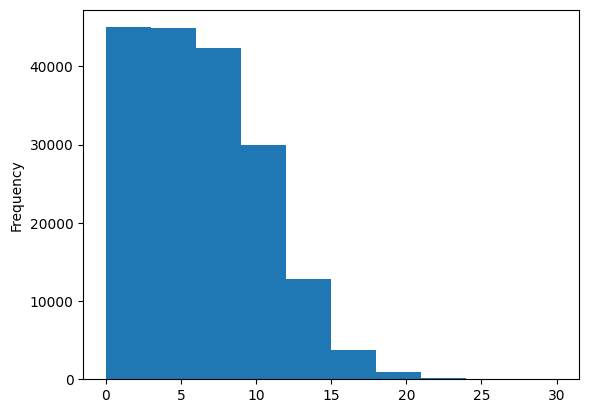

In [124]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [125]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape


(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [126]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


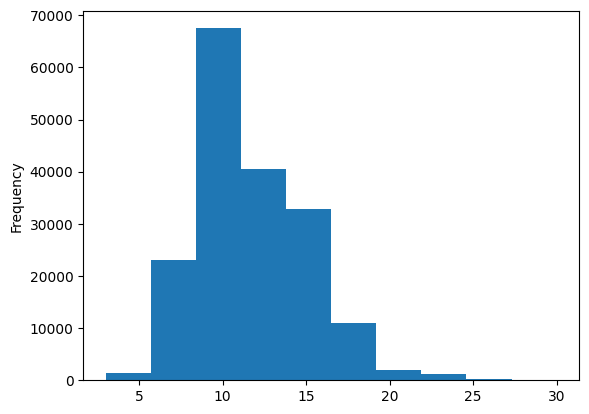

In [127]:

# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [128]:

# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

np.float64(20.0)

In [129]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

# **Building a tribrid embedding model**

1 Create a token-level model


3 Create a model for the "line_number" feature

4 Create a model for the "total_lines" feature

5 Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate

6 Combine the outputs of 3, 4, 5 using tf.keras.layers.Concatenate

7 Create an output layer to accept the tribrid embedding and output label probabilities

8 Combine the inputs of 1, 2, 3, 4 and outputs of into a tf.keras.Model

In [132]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = UniversalSentenceEncoderLayer()(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
# inputs, shape = ?
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
# dense layer with 32 units & relu activation
x = layers.Dense(32, activation="relu")(line_number_inputs)
# combine inputs & dense layer into model
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# 7. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

In [133]:
# Get a summary of our tribrid embedding model
model_5.summary()

Model: "model_5_tribrid_embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_inputs         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_inputs        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_inputs[0][0] │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ token_inputs[0][… │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │        700 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_9         │ (None, 290)       │          0 │ char_vectorizer[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 48)        │      9,600 │ char_embed[8][0], │
│ (Bidirectional)     │                   │            │ not_equal_9[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_hybrid_… │ (None, 176)       │          0 │ dense_9[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ total_lines_input   │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │     45,312 │ char_token_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 32)        │        512 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │        672 │ total_lines_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_token_positio… │ (None, 320)       │          0 │ dense_10[0][0],   │
│ (Concatenate)       │                   │            │ dense_11[0][0],   │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      1,605 │ char_token_posit… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 124,065 (484.63 KB)

 Trainable params: 124,065 (484.63 KB)

 Non-trainable params: 0 (0.00 B)